In [1]:
from transformers import CLIPProcessor, CLIPModel
import torch
from torch.utils.data import DataLoader
import pickle
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import seaborn as sb


/Users/lixinmei/miniconda3/envs/aero/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')

In [53]:
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

In [54]:
ds = pickle.load(open('/Users/lixinmei/Desktop/vscode_workspace/aeroimagery/AID/dataset.pkl', 'rb'))

In [56]:
class Clissifier(torch.nn.Module):

    def __init__(self, processor, model, class_labels, prefix="satellite image of "):
        super().__init__()
        self.model = model
        self.processor = processor
        self.prefix = prefix
        self.class_labels = [self.prefix + label for label in class_labels]
        self.model.eval()

    def forward(self, x):
        model_input = self.processor(self.class_labels, x, return_tensors="pt", padding=True)
        model_output = self.model(**model_input)

        # get the max in the output
        logits = model_output.logits_per_image
        # print(model_output.logits_per_image)
        max_labels = torch.argmax(logits, dim=1)
        return max_labels


In [92]:
classifier = Clissifier(processor, model, ds.dataset.features['label'].names, prefix="satellite image of ")

In [93]:
classifier.class_labels

['satellite image of Airport',
 'satellite image of BareLand',
 'satellite image of BaseballField',
 'satellite image of Beach',
 'satellite image of Bridge',
 'satellite image of Center',
 'satellite image of Church',
 'satellite image of Commercial',
 'satellite image of DenseResidential',
 'satellite image of Desert',
 'satellite image of Farmland',
 'satellite image of Forest',
 'satellite image of Industrial',
 'satellite image of Meadow',
 'satellite image of MediumResidential',
 'satellite image of Mountain',
 'satellite image of Park',
 'satellite image of Parking',
 'satellite image of Playground',
 'satellite image of Pond',
 'satellite image of Port',
 'satellite image of RailwayStation',
 'satellite image of Resort',
 'satellite image of River',
 'satellite image of School',
 'satellite image of SparseResidential',
 'satellite image of Square',
 'satellite image of Stadium',
 'satellite image of StorageTanks',
 'satellite image of Viaduct']

In [94]:
# transform = transforms.Compose([transforms.ToTensor()])
transform = transforms.Compose([
    transforms.functional.pil_to_tensor,
    lambda x: x.permute(1, 2, 0),
    lambda x: x * 255,
    lambda x: x.type(torch.uint8),
])

In [95]:
def my_collate(batch):
    '''
    input: list of dict {image: PIL.Image, label: int}
    output: dict {image: torch.Tensor, label: torch.Tensor}
    '''
    # return {'image': torch.stack([x['image'] for x in batch]), 'label': torch.tensor([x['label'] for x in batch])}
    image_tensor = torch.stack([transform(x['image']) for x in batch])
    label_tensor = torch.tensor([x['label'] for x in batch])
    return {'image': image_tensor, 'label': label_tensor}

In [96]:
dl = DataLoader(ds, batch_size=32, collate_fn=my_collate)

In [97]:
first_batch = next(iter(dl))

In [98]:
first_batch['image'].shape

torch.Size([32, 600, 600, 3])

In [99]:
first_batch['image'].shape

torch.Size([32, 600, 600, 3])

In [100]:
first_image = ds[0]['image']

In [101]:
first_tensor_image = transform(first_image)

In [102]:
classifier(first_tensor_image)

tensor([0])

In [103]:
first_numpy_image = np.array(first_image.getdata()).reshape(600, 600, 3)

In [104]:
# classifier(first_numpy_image)

In [105]:
first_tensor_image.shape, first_numpy_image.shape

(torch.Size([600, 600, 3]), (600, 600, 3))

In [106]:
with torch.no_grad():
    confusion_matrix = torch.zeros(len(classifier.class_labels), len(classifier.class_labels))
    bar = tqdm(total=len(ds), desc='running prediction')
    # for batch in dl:
    for batch in ds:
        # print(batch['label'])
        logits = classifier(batch['image'])
        # print(logits)
        truth = batch['label']
        confusion_matrix[truth, logits] += 1
        # print(truth, logits)
        # bar.update(len(truth))
        bar.update(1)


        # print(ds.features['label'].names[logits])

running prediction: 100%|██████████| 1500/1500 [03:35<00:00,  6.95it/s]


<Axes: >

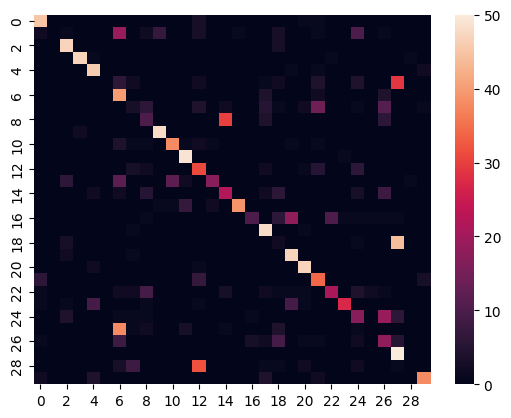

In [110]:
sb.heatmap(confusion_matrix)

In [111]:
# accuracy
tp = confusion_matrix.diag()
accuracy = tp.sum() / len(ds)


In [112]:
accuracy

tensor(0.5607)

In [113]:
confusion_matrix.sum(axis=1)

tensor([50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
        50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
        50., 50.])